# Compute `SEDFRAC`

`SEDFRAC` is the fraction of each grid cell at each detpth that contains subgrid-scale bottom sediment.

This procedure has the following steps.
1. Compute mapping weights for `etopo_grid` to `ocean_grid` using ESMF `conservative` scheme.
1. At each cell in `ocean_grid`, find all contributing `etopo_grid` cells; bin the data on the model vertical grid and sum the weights at each depth.
1. Normalize the resulting matrix by dividing by the sum of the weights over depth.
1. Write netCDF file for computation of [Fe sediment flux on subgrid-scale bathymetry](Fe_sediment_flux_forcing.ipynb).


In [38]:
%matplotlib inline
import os
import tqdm

import numpy as np
import xarray as xr
import scipy.sparse as sps

import matplotlib.pyplot as plt

import esmlab
import pop_tools

import util

## Get grid and mapping files

Here we are assuming that several grid files and a conservative mapping file between them exists.

- `_ensure_grid_files.ipynb` generates the ETOPO1 SCRIP grid file;
- `esmf_gen_weights_etopo1_to_POP.pbs` uses an MPI implementation of `ESMF_RegridWeightGen` to compute mapping files.

In [39]:
dst_grid = 'POP_gx1v7'

In [40]:
src_grid = 'etopo1'

file_src_grid = util.file_name_grid(src_grid)
file_dst_grid = util.file_name_grid(dst_grid)
file_weights = util.file_name_weight(src_grid, dst_grid, 'conservative')

src = xr.open_dataset(file_src_grid)
dst = xr.open_dataset(file_dst_grid)
mf = xr.open_dataset(file_weights)

In [41]:
dims_dst = tuple(dst.grid_dims.values[::-1])
dims_src = tuple(src.grid_dims.values[::-1])

n_dst = np.prod(dims_dst)
n_src = np.prod(dims_src)

Convert mapping file to sparse matrix.

In [42]:
%%time
row = mf.row.values - 1
col = mf.col.values - 1
S = mf.S.values
A = sps.csr_matrix((S, (row, col)), shape=[n_dst, n_src])

CPU times: user 3.33 s, sys: 27.2 s, total: 30.6 s
Wall time: 2min 22s


## Read topographic data

Read the data, set the `data_src`, mask out positive values (land) and make positive-down. Make a quick plot.

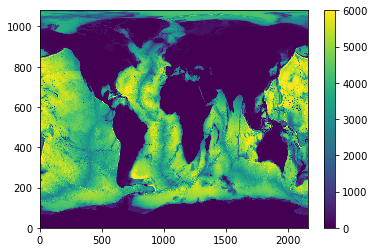

In [43]:
file_src_data = util.datasets['etopo1']['urlpath']
with xr.open_dataset(file_src_data) as ds:
    data_src = ds.z.values
    
data_src = np.where(data_src > 0., 0., -1.0 * data_src)
plt.pcolormesh(data_src[::10, ::10], vmin=0, vmax=6000.)
plt.colorbar()

Sanity check: Remap `data_src` to destination grid. Does this look like the field above?  It should.

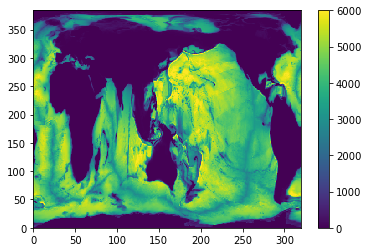

In [44]:
data_src_flat = data_src.reshape(-1, n_src)

data_dst_flat = A.dot(data_src_flat.T).T

data_dst = data_dst_flat.reshape(dims_dst)
plt.pcolormesh(data_dst, vmin=0, vmax=6000.)
plt.colorbar()

## Make the model vertical coordinate into a depth bins array

In [45]:
ds_dst_grid = pop_tools.get_grid(dst_grid)
zbins_e = np.concatenate((ds_dst_grid.z_w.values, [ds_dst_grid.z_w_bot.values[-1]]))
zbins_e = zbins_e * 1e-2
z_t = ds_dst_grid.z_t.values * 1e-2
zbins_e

array([   0.      ,   10.      ,   20.      ,   30.      ,   40.      ,
         50.      ,   60.      ,   70.      ,   80.      ,   90.      ,
        100.      ,  110.      ,  120.      ,  130.      ,  140.      ,
        150.      ,  160.      ,  170.196808,  180.761292,  191.821243,
        203.499313,  215.923446,  229.233124,  243.584534,  259.155793,
        276.152589,  294.814713,  315.423736,  338.312257,  363.874728,
        392.580478,  424.98885 ,  461.766575,  503.706883,  551.749119,
        606.996663,  670.728582,  744.39803 ,  829.606956,  928.043538,
       1041.368196, 1171.040188, 1318.093626, 1482.900716, 1664.992064,
       1863.014408, 2074.873978, 2298.039076, 2529.904017, 2768.098509,
       3010.670677, 3256.13847 , 3503.448607, 3751.891888, 4001.011634,
       4250.524544, 4500.260482, 4750.120091, 5000.046829, 5250.00927 ,
       5499.990364])

Read the model topography file

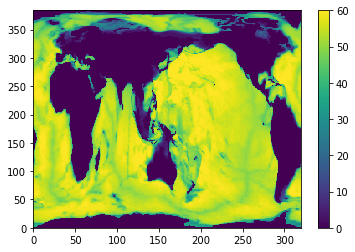

In [46]:
topo_file = util.file_name_pop_topography(dst_grid)
kmt_flat = np.fromfile(topo_file, dtype='>i4', count=-1)

assert kmt_flat.shape[0] == np.prod(dims_dst)
assert kmt_flat.max() <= len(z_t)

kmt = kmt_flat.reshape(dims_dst)
plt.pcolormesh(kmt)
plt.colorbar()

## Compute `sedfrac`

Find the points that map to each cell in the destination grid. Sum the weights from these points. 

In [47]:
%%time
data_src_flat_sq = np.squeeze(data_src_flat)

nk = len(zbins_e)-1

# sum of weights at each depth level
wsum_dst_flat = np.zeros((nk, n_dst)) 

# the data from source grid mapped to each depth level
data_dst_flat = np.zeros((nk, n_dst)) 


def map_point_i(i):
    
    # local slices of weights and data
    wsum_dst_flat_i = np.zeros((nk)) 
    data_dst_flat_i = np.zeros((nk)) 

    # find the points in the source grid that map to point i   
    # mapped_points = column indices of mapped points
    # w = the weights for each mapped point
    _, mapped_points, w = sps.find(A.getrow(i))

    # get the data from the source grid
    mapped_data = data_src_flat_sq[mapped_points].copy()

    # mask out where data are not in range
    mapped_data[mapped_data <= 0] = -1
    if all(mapped_data == -1) or kmt_flat[i] == 0: 
        return wsum_dst_flat_i, data_dst_flat_i

    # truncate the depth bins according to KMT (the index of the deepest cell)
    zbins_e_i = zbins_e[:kmt_flat[i]+1].copy()
    zmax_i = zbins_e_i[-1].copy()
    zbins_e_i[-1] = 1e30 # set to a large value such that depth below the max depth model map to the bottom
    
    # bin the data in depth
    ind_zbin = np.searchsorted(zbins_e_i, mapped_data, side='left')

    # replace the topo data larger than zmax_i with zmax_i
    mapped_data = np.where(mapped_data > zmax_i, zmax_i, mapped_data)

    # loop over mapped points and sum weights at each k-level
    for n in range(mapped_data.size):
        k = ind_zbin[n] - 1
        if k < 0: continue
        wsum_dst_flat_i[k] += w[n]
        data_dst_flat_i[k] += w[n] * mapped_data[n]
        
    return wsum_dst_flat_i, data_dst_flat_i

# loop over points in destination grid
result = []
for i in range(n_dst):
    result.append(map_point_i(i))


CPU times: user 8min 41s, sys: 1min 18s, total: 9min 59s
Wall time: 11min 18s


In [48]:
for i, (wsum, data) in enumerate(result):
    wsum_dst_flat[:, i] = wsum
    data_dst_flat[:, i] = data
    
data_dst_flat = data_dst_flat / np.where(wsum_dst_flat==0., np.nan, wsum_dst_flat)
    
wtot_dst_flat = wsum_dst_flat.sum(axis=0)
wtot_dst_flat = np.where(wtot_dst_flat==0., np.nan, wtot_dst_flat)
wsum_dst_flat = wsum_dst_flat / wtot_dst_flat


wtot_dst = wtot_dst_flat.reshape(dims_dst)
wsum_dst = wsum_dst_flat.reshape((nk,)+dims_dst)
data_dst = data_dst_flat.reshape((nk,)+dims_dst)

The last index into the sum of weights should includes `ones` in the deepest grid cells.

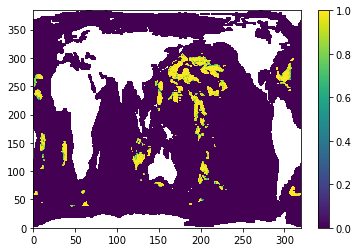

In [49]:
plt.pcolormesh(wsum_dst[-1, :, :])
plt.colorbar()

Transect up the middle of the Pacific

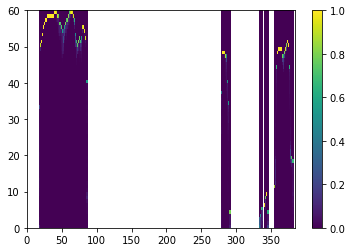

In [50]:
plt.pcolormesh(wsum_dst[:, :, 60])
plt.colorbar()

Normalized weights should sum to `one` everywhere in the column.

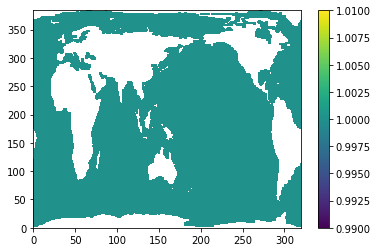

In [51]:
plt.pcolormesh(wsum_dst.sum(axis=0), vmin=0.99, vmax=1.01)
plt.colorbar()

column_sum = wsum_dst.sum(axis=0)
column_sum = column_sum[~np.isnan(column_sum)]
np.testing.assert_allclose(column_sum, 1.)

The sum of the weights in the column should equal `one` in the open ocean; it will be less than one adjacent to land.

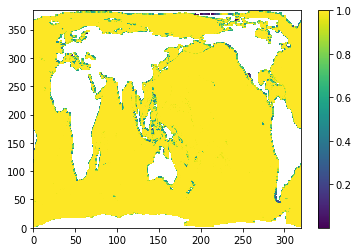

In [52]:
plt.pcolormesh(wtot_dst)
plt.colorbar()

The remapped topography should look like topography, in the right `z` level!

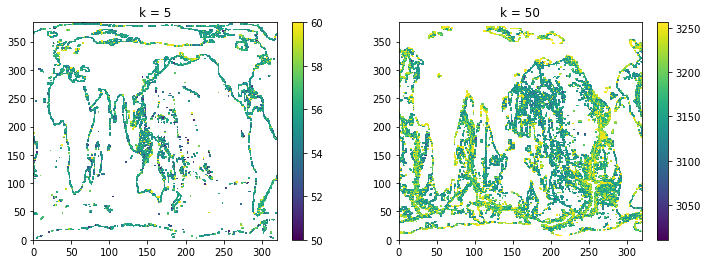

In [53]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
k = 5
plt.pcolormesh(data_dst[k, :, :], vmin=zbins_e[k], vmax=zbins_e[k+1])
plt.colorbar()
plt.title(f'k = {k}')

fig.add_subplot(1, 2, 2)
k = 50
plt.pcolormesh(data_dst[k, :, :], vmin=zbins_e[k], vmax=zbins_e[k+1])
plt.colorbar()
plt.title(f'k = {k}')

for k in range(nk):
    data_at_k = data_dst[k, :, :].reshape(-1)
    data_at_k = data_at_k[~np.isnan(data_at_k)]

    assert (data_at_k <= zbins_e[k+1]+1e-7).all()
    assert (zbins_e[k]-1e-7 < data_at_k).all()

In [54]:
dso = xr.Dataset()
dso['sedfrac'] = xr.DataArray(wsum_dst, dims=('z_t', 'nlat', 'nlon'))
dso['sum_of_weights'] = xr.DataArray(wtot_dst, dims=('nlat', 'nlon'))
dso['remapped_topography'] = xr.DataArray(data_dst, dims=('z_t', 'nlat', 'nlon'))
dso['z_t'] = xr.DataArray(z_t * 1e2, dims=('z_t'))
dso.z_t.encoding['_FillValue'] = None

In [55]:
print(f'writing {util.sedfrac_file(dst_grid)}')
dso.to_netcdf(util.sedfrac_file(dst_grid))

writing /glade/work/mclong/cesm_inputdata/work/sedfrac.POP_gx1v7.nc
